In [1]:
# Imports for data handling
import string
import re
import itertools
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# Imports for modeling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

# NLP imports
from nltk import download
from nltk.corpus import stopwords
from nltk import word_tokenize, download, Text
from gensim.models import LdaModel, LdaMulticore, TfidfModel
from gensim.corpora import Dictionary

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import seaborn as sns
sns.set()

download("stopwords")
download("punkt")

[nltk_data] Downloading package stopwords to /home/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/andrew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Selecting colorblind friendly colors for plotting
c_or, c_purp, c_blue = '#ee442f', '#601a4a', '#63acbe'

## Tweet Counts

We exported the [Trump Twitter Archive](http://www.trumptwitterarchive.com/archive) in CSV format. First we convert the `created_at` column to a datetime.

In [3]:
tweets_raw = pd.read_csv("data/tweet_archive_raw.csv")

display(tweets_raw.head())
print(tweets_raw.created_at.dtype)

tweets_raw.created_at = pd.to_datetime(tweets_raw.created_at, errors="coerce")
print(tweets_raw.created_at.dtype)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,KENTUCKY! #KYGov Get out today and VOTE for @...,11-05-2019 20:42:10,8141.0,24368,false,1.191818e+18
1,Twitter for iPhone,Thank you so much CLUB 45. You are truly Great...,11-05-2019 18:58:07,11893.0,42053,false,1.191792e+18
2,Twitter for iPhone,RT @Club45USA: Club 45 on NBC Today Show. Show...,11-05-2019 18:56:03,5123.0,0,true,1.191791e+18
3,Twitter for iPhone,KENTUCKY! Get out today and VOTE for @MattBev...,11-05-2019 17:19:46,10589.0,31281,false,1.191767e+18
4,Twitter for iPhone,RT @GOPChairwoman: If you want to defeat the r...,11-05-2019 17:15:42,6400.0,0,true,1.191766e+18


object
datetime64[ns]


We want to examine the number of tweets per day, so we aggregated the data by date and counted the rows.

In [4]:
# group tweets by date and count rows
tweet_counts = tweets_raw.groupby(tweets_raw.created_at.dt.date)["text"].count()
tweet_counts = tweet_counts.to_frame(name="tweet_count")
tweet_counts.index.name = "date"
tweet_counts.reset_index(inplace=True)

# I think resetting the index changes the date back to a string
tweet_counts.date = pd.to_datetime(tweet_counts.date)
display(tweet_counts.head())

,date,tweet_count
0,2009-05-04,1
1,2009-05-05,1
2,2009-05-08,2
3,2009-05-12,2
4,2009-05-13,1


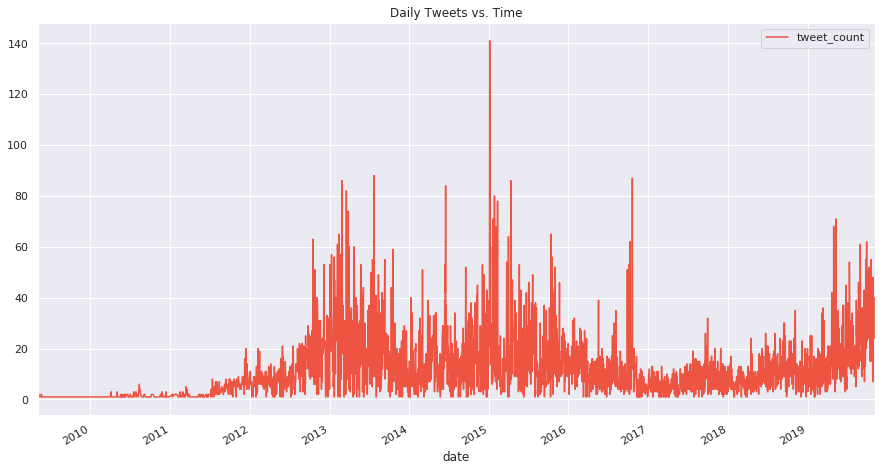

In [7]:
tweet_counts.plot(x="date", y="tweet_count", figsize=(15, 8),
                  title="Daily Tweets vs. Time", color=c_or, alpha=0.9);

plt.savefig('figs/daily_tweet_v_time.png', dpi=200)

The dataset extends back to 2009, and there are obvious qualitative differences in daily counts across the. years. Because our question is focused on the relationship between approval rating, stock market movement, and tweet frequency, we chose to subset the data to the years Donald Trump has been in office (and therefore for which we have approval ratings). For simplicity, we kept all tweets from 2017 onward (he took office in January 2017).

In [8]:
tweet_counts = tweet_counts[tweet_counts.date.dt.year >= 2017]

display(tweet_counts.head())

,date,tweet_count
2017,2017-01-01,6
2018,2017-01-02,7
2019,2017-01-03,10
2020,2017-01-04,10
2021,2017-01-05,6


Let's examine the distribution of tweet counts.

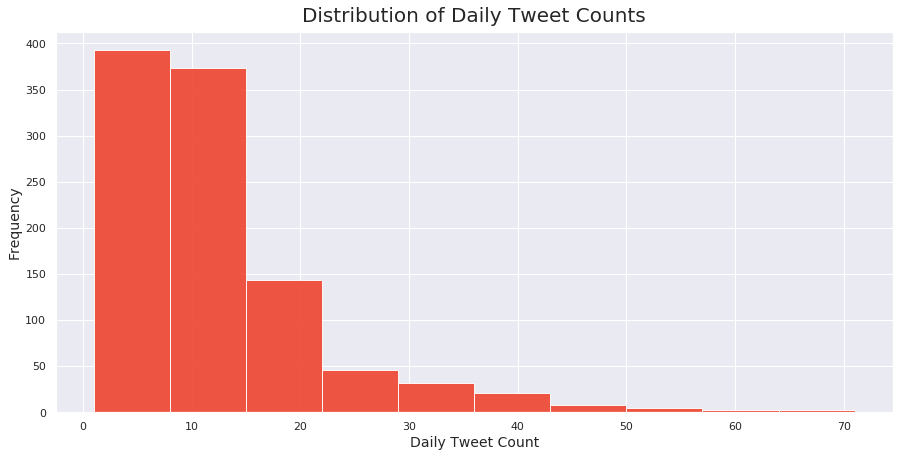

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.hist(tweet_counts.tweet_count, color=c_or, alpha=0.9)
ax.set_title("Distribution of Daily Tweet Counts", fontsize=20, y=1.01)
ax.set_xlabel("Daily Tweet Count", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14);

fig.savefig('figs/dist_daily_tweet_c.png', dpi=200)

The counts are skewed right. We must address this if we use a model that expects a normally distributed outcome (perhaps by log-transforming the counts).

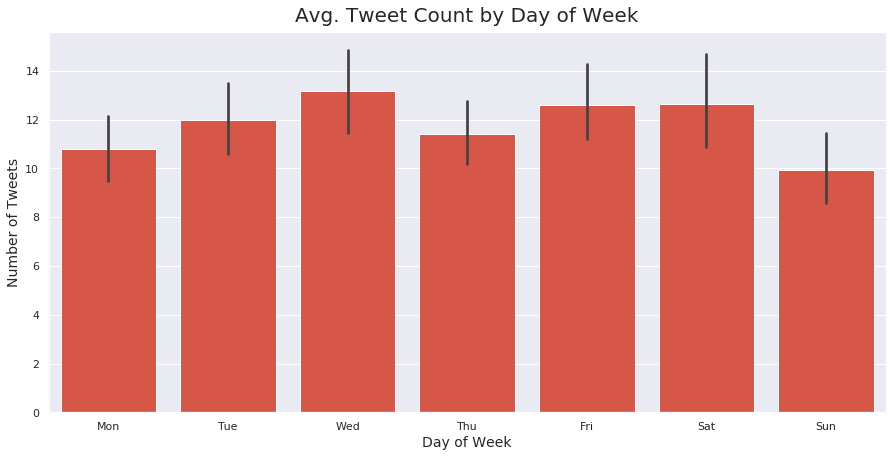

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))

sns.barplot(data=tweet_counts, x=tweet_counts.date.dt.weekday, y="tweet_count", color=c_or)
ax.set_xticklabels(("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"))
ax.set_xlabel("Day of Week", fontsize=14)
ax.set_ylabel("Number of Tweets", fontsize=14)
ax.set_title("Avg. Tweet Count by Day of Week", fontsize=20, y=1.01);

fig.savefig('figs/avg_tweet_count_day_of_week.png', dpi=200)

Examining tweet count by weekday suggests that the day of the week might be a useful predictor of tweet counts.

## Approval Data

The data-driven news organization fivethirtyeight publishes a [continuous model of Trump's approval](https://projects.fivethirtyeight.com/trump-approval-ratings/?ex_cid=rrpromo) and disapproval rating that aggregates many individual polls from various sources. They publish the output of their model (estimates of approval and disapproval rating [in a GitHub repository](https://github.com/fivethirtyeight/data/tree/master/trump-approval-ratings).

In [11]:
approval_raw = pd.read_csv("data/fivethirtyeight_approval_raw.csv")
display(approval_raw.head())


,president,subgroup,modeldate,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,timestamp
0,Donald Trump,Voters,11/11/2019,42.422535,46.998677,37.846392,53.942433,58.351125,49.533742,13:39:48 11 Nov 2019
1,Donald Trump,Adults,11/11/2019,40.888467,44.708000,37.068935,54.354874,58.893496,49.816252,13:38:40 11 Nov 2019
2,Donald Trump,All polls,11/11/2019,41.388833,46.004746,36.772920,54.253333,58.650904,49.855761,13:37:55 11 Nov 2019
3,Donald Trump,Voters,11/10/2019,42.345681,46.897453,37.793909,54.145162,58.678856,49.611468,18:59:31 10 Nov 2019
4,Donald Trump,All polls,11/10/2019,41.388620,45.879349,36.897892,54.327700,58.818030,49.837371,18:54:55 10 Nov 2019


Like the tweet data, we will type cast the timestamp. Examining the minimum, we see we are already limited to data from 2017 and later.

In [12]:
approval_raw.timestamp = pd.to_datetime(approval_raw.timestamp, errors="coerce")

print(approval_raw.timestamp.dtype)
print(f"Earliest observation: {approval_raw.timestamp.min()}")

datetime64[ns]
Earliest observation: 2017-03-02 11:25:44


We noticed there are different estimates for the population of the polls that went into their model. We plotted the individual points by date and subgroup.

In [13]:
approval_raw.subgroup.unique()

array(['Voters', 'Adults', 'All polls'], dtype=object)

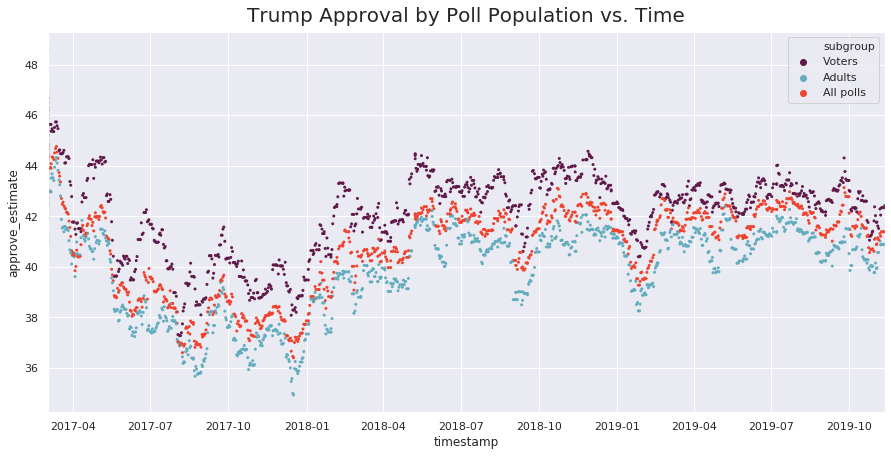

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

sns.scatterplot(data=approval_raw, x="timestamp", y="approve_estimate", 
                hue="subgroup", ax=ax, palette=[c_purp, c_blue, c_or],
                linewidth=0, marker='.')

ax.set_title("Trump Approval by Poll Population vs. Time", fontsize=20, y=1.01)
ax.set_xlim(approval_raw.timestamp.min(), approval_raw.timestamp.max());

fig.savefig('figs/trump_approval_time.png', dpi=200)

We saw that the subgroups move almost exactly with one another, so we chose to use only the "all polls" observations (rather than potentially introduce bias from limiting the population subgroup).

In [16]:
# subset to 'All polls', group by date, and average.
# (some days have more than one poll, but averaging seems reasonable)
approval = approval_raw.loc[approval_raw.subgroup == "All polls"]
approval = approval.groupby(approval.timestamp.dt.date).mean()
approval.index.name = "date"
approval.reset_index(inplace=True)
approval.date = pd.to_datetime(approval.date)
display(approval.head())

,date,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo
0,2017-03-02,44.164797,48.814171,39.515424,47.590546,52.241763,42.939329
1,2017-03-03,43.902260,48.675100,39.129430,49.856540,54.372810,45.340270
2,2017-03-05,43.936930,48.763720,39.110130,49.726230,54.272490,45.179980
3,2017-03-06,43.992985,48.685735,39.300240,49.576445,54.080370,45.072520
4,2017-03-07,44.345500,48.879220,39.811780,48.891240,53.461960,44.320520


The dataset includes approval and disapproval estimates; we expect these to be highly correlated.

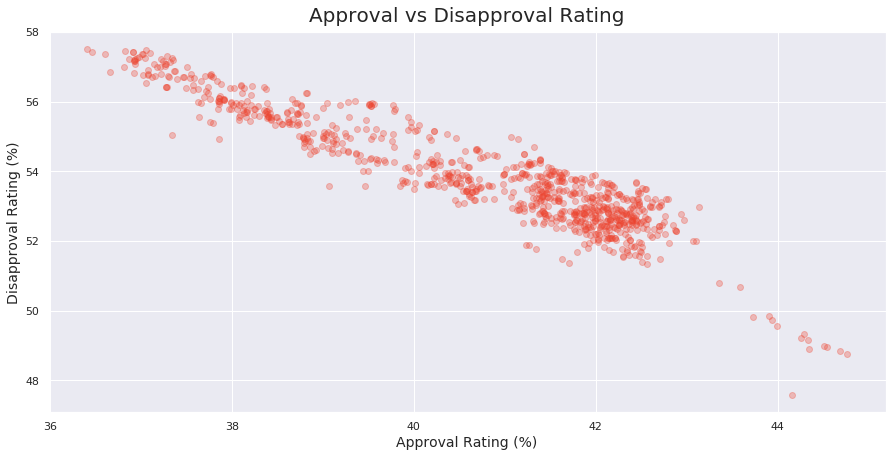

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(approval.approve_estimate, approval.disapprove_estimate, color=c_or, alpha=0.3)
ax.set_xlabel("Approval Rating (%)", fontsize=14)
ax.set_ylabel("Disapproval Rating (%)", fontsize=14)
ax.set_title("Approval vs Disapproval Rating", fontsize=20, y=1.01);

fig.savefig('figs/plot_approval_v_disapp.png', dpi=200)

In [18]:
np.corrcoef(approval.approve_estimate, approval.disapprove_estimate)[0, 1]

-0.9302800085191135

This is indeed the case; including both these predictors in a model will result in strong multicollinearity.

## Financial Markets Data

Before selecting the financial data we first explored multiple sources to see which would provide the best option. Quandl, Tiingo, Yahoo and the data provided with the project were considered. Given that our objective was to predict the frequency of Trump’s Tweets by market movement, we felt the best option would use the finance data that is most likely to show up on cable news instead of more detailed futures and options data. From here we explored the other options, but Yahoo was the only option that was both free, and didn’t have overly complex rules about how the data could be used or shared.

In addition to SPY, we included VIX as a way to capture the hyped that might be shown on market and cable news channels. It is a decent way of judging market sentiment.

In [19]:
# Read in spy daily csv
df = pd.read_csv('data/spy_daily.csv')

Now that we have imported SPY, it is time to clean it up and add a few useful columns.

In [20]:
# Update time to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create new column representing the total change from open to close
df['Change'] = df['Open'] - df['Close']

# Create a column showing the percentage change during the day
df['Daily_Perc'] = df['Change'] / df['Open'] * 100

# Create a column showing the intraday swing, and one that represents %
df['Intraday'] = df['High'] - df['Low']
df['Intraday_Perc'] = df['Intraday'] / df['Open'] * 100

Now lets do the same with VIX, but also delete columns which are redundant for capturing market volatile.

In [21]:
# Import VIX daily csv
df_vix = pd.read_csv('data/vix_daily.csv')

In [22]:
# Update column names so they are unique when merging
for col in df_vix:
    df_vix[f'vix_{col}'] = df_vix[col]
    del df_vix[col]

# Merge vix and spy by columns    
df_all = pd.concat([df, df_vix], axis=1)

# Delete useless or repeat columns
del df_all['vix_Date']
del df_all['vix_Volume']
del df_all['vix_Adj Close']
del df_all['Adj Close']

# Create columns for daily change and %
df_all['vix_Change'] = df_all['vix_Open'] - df_all['vix_Close']
df_all['vix_Daily_Perc'] = df_all['vix_Change'] / df_all['vix_Open'] * 100

# Capture intraday swing
df_all['vix_Intraday'] = df_all['vix_High'] - df_all['vix_Low']
df_all['vix_Intraday_Perc'] = df_all['vix_Intraday'] / df_all['vix_Open'] * 100

# Useless, so delete
del df_all['vix_Intraday_Perc']

Some useful refrence point might be season, and day. Adding them for possible later use.

In [23]:
# Append the day of the week to the dataframe starting 0 for monday
days = []

for day in df_all['Date']:
    days.append(day.weekday())
    
df_all['Weekday'] = days

season = []
winter = [12,1,2]
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]

for t in df_all['Date']:
    if t.month in winter:
        season.append('winter')
    elif t.month in spring:
        season.append('spring')
    elif t.month in summer:
        season.append('summer')
    elif t.month in fall:
        season.append('fall')
    else:
        print('omg')
        
df_all['Season'] = season

Export for team to explore.

In [24]:
# Export dataframe to csv
df_all.to_csv('data/spy_vix_daily.csv')

Import and rename to proceed.

In [25]:
markets = pd.read_csv("data/spy_vix_daily.csv")

In [26]:
display(markets.head())

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Change,Daily_Perc,Intraday,Intraday_Perc,vix_Open,vix_High,vix_Low,vix_Close,vix_Change,vix_Daily_Perc,vix_Intraday,Weekday,Season
0,0,2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,3770530000,-6.260010,-0.278029,18.750000,0.832752,14.07,14.07,12.85,12.85,1.22,8.670931,1.22,1,winter
1,1,2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,3764890000,-9.149902,-0.404576,11.219970,0.496108,12.78,12.80,11.63,11.85,0.93,7.276995,1.17,2,winter
2,2,2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,3761820000,-0.820068,-0.036155,11.050049,0.487177,11.96,12.09,11.40,11.67,0.29,2.424749,0.69,3,winter
3,3,2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,3339890000,-5.840087,-0.257143,18.040039,0.794317,11.70,11.74,10.98,11.32,0.38,3.247863,0.76,4,winter
4,4,2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,3217610000,4.690186,0.206290,6.590088,0.289854,11.71,12.08,11.46,11.56,0.15,1.280956,0.62,0,winter


Again, we cast the date column. Additionally we drop the extra index column.

In [27]:
markets["date"] = pd.to_datetime(markets.Date)
markets.drop(["Unnamed: 0"], axis=1, inplace=True)

In [28]:
display(markets.head())
print(markets.date.dtype)

,Date,Open,High,Low,Close,Volume,Change,Daily_Perc,Intraday,Intraday_Perc,vix_Open,vix_High,vix_Low,vix_Close,vix_Change,vix_Daily_Perc,vix_Intraday,Weekday,Season,date
0,2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,3770530000,-6.260010,-0.278029,18.750000,0.832752,14.07,14.07,12.85,12.85,1.22,8.670931,1.22,1,winter,2017-01-03
1,2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,3764890000,-9.149902,-0.404576,11.219970,0.496108,12.78,12.80,11.63,11.85,0.93,7.276995,1.17,2,winter,2017-01-04
2,2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,3761820000,-0.820068,-0.036155,11.050049,0.487177,11.96,12.09,11.40,11.67,0.29,2.424749,0.69,3,winter,2017-01-05
3,2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,3339890000,-5.840087,-0.257143,18.040039,0.794317,11.70,11.74,10.98,11.32,0.38,3.247863,0.76,4,winter,2017-01-06
4,2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,3217610000,4.690186,0.206290,6.590088,0.289854,11.71,12.08,11.46,11.56,0.15,1.280956,0.62,0,winter,2017-01-09


datetime64[ns]


For reference, the variables without a prefix correspond to the [SPY](https://us.spdrs.com/en/etf/spdr-sp-500-etf-trust-SPY) ETF, which tracks the S&P 500 index. Those prefixed with `vix` refer to the [VIX index](http://www.cboe.com/vix), which measures volatility (of options in the S&P).

We need to examine the relationship between the two indices' behavior; for ease of visualization, we will drop the weekday column for now.

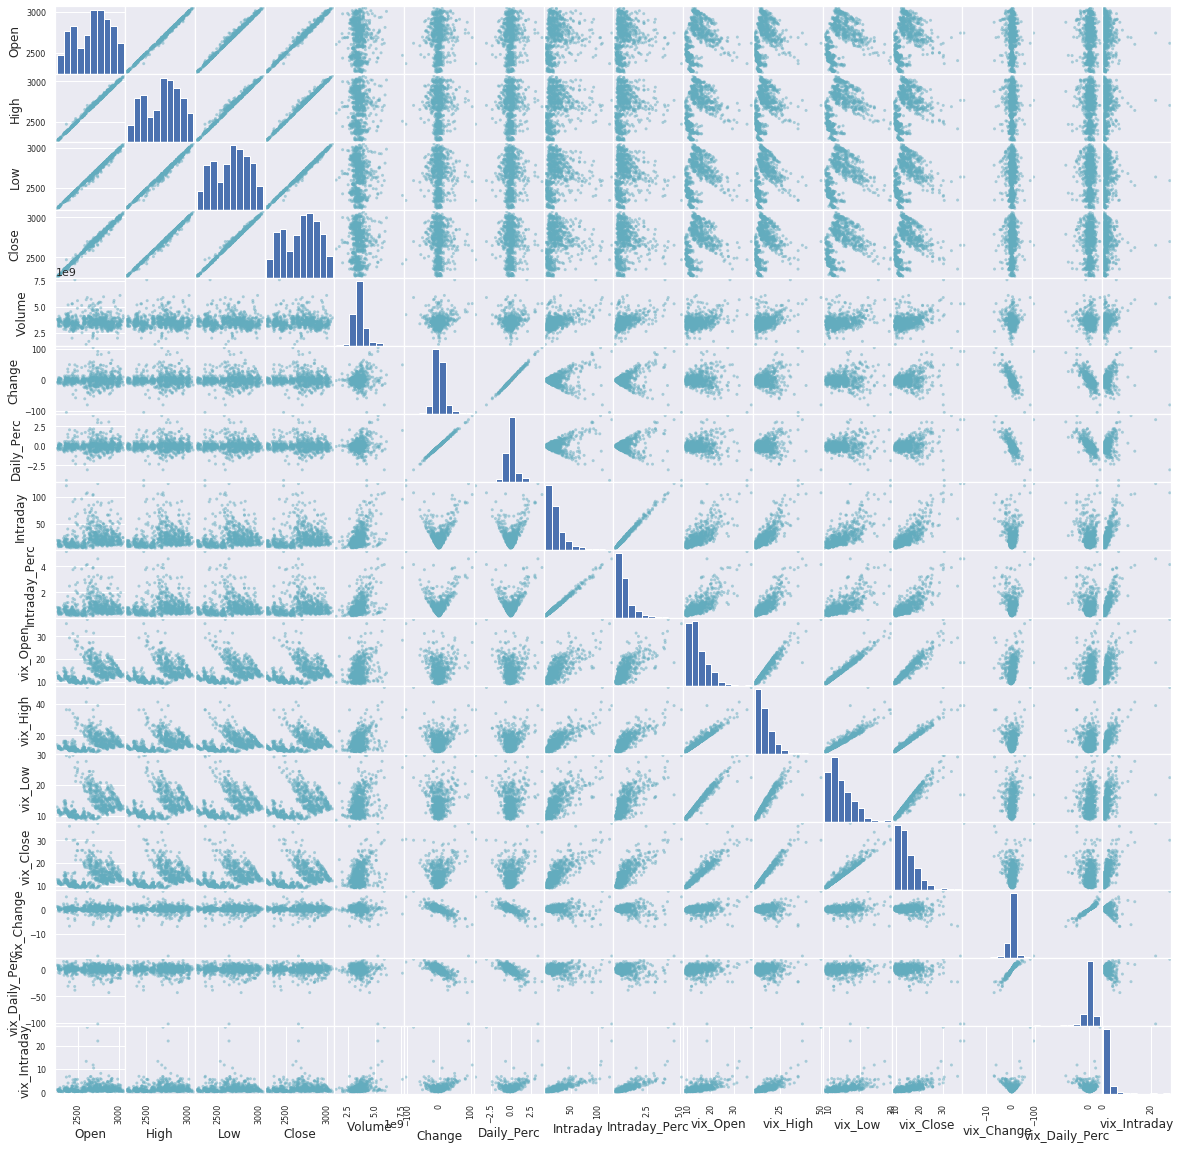

<Figure size 432x288 with 0 Axes>

In [29]:
pd.plotting.scatter_matrix(markets.drop(["Weekday"], axis=1), figsize=(20, 20), color=c_blue)
plt.show()
plt.savefig('market_scatter_matrix.png', dpi=200)

Several key observations and relationships we consider relevant:

- There is a clear negative correlation bewteen SPY daily change and VIX daily change
- The correlation between SPY and VIX prices (open, close) is less straightforward. When VIX is low, there does not appear to be a correlation. As VIX increases (meaning volatility is high), we see a negative relationship between VIX and SPY prices.
- Daily change (in percent) of both indices is roughly normally distributed.
- The histogram of VIX changes suggests potential outliers

We can zoom in on these relationships:

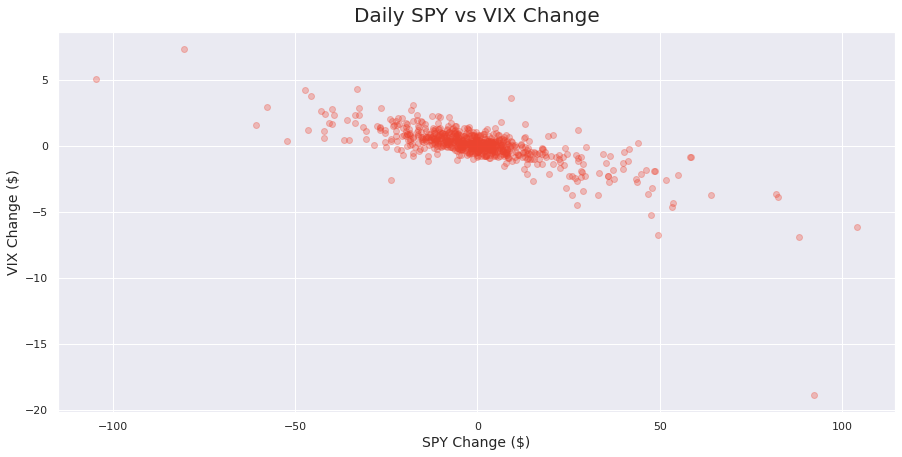

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(markets.Change, markets.vix_Change, alpha=0.3, color=c_or)
ax.set_xlabel("SPY Change ($)", fontsize=14)
ax.set_ylabel("VIX Change ($)", fontsize=14)
ax.set_title("Daily SPY vs VIX Change", fontsize=20, y=1.01);

fig.savefig('figs/plot_spy_vix.png', dpi=200)

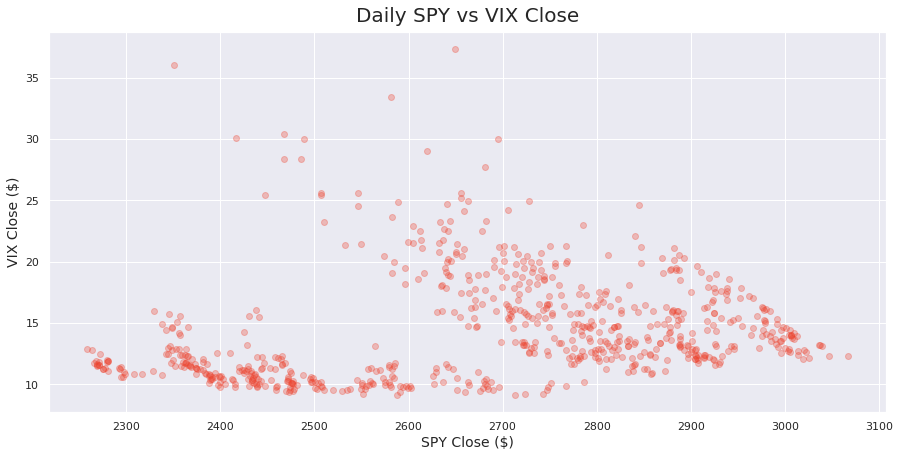

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.scatter(markets.Close, markets.vix_Close, alpha=0.3, color=c_or)
ax.set_xlabel("SPY Close ($)", fontsize=14)
ax.set_ylabel("VIX Close ($)", fontsize=14)
ax.set_title("Daily SPY vs VIX Close", fontsize=20, y=1.01);

fig.savefig('figs/plot_spyclose_vixclose.png', dpi=200)

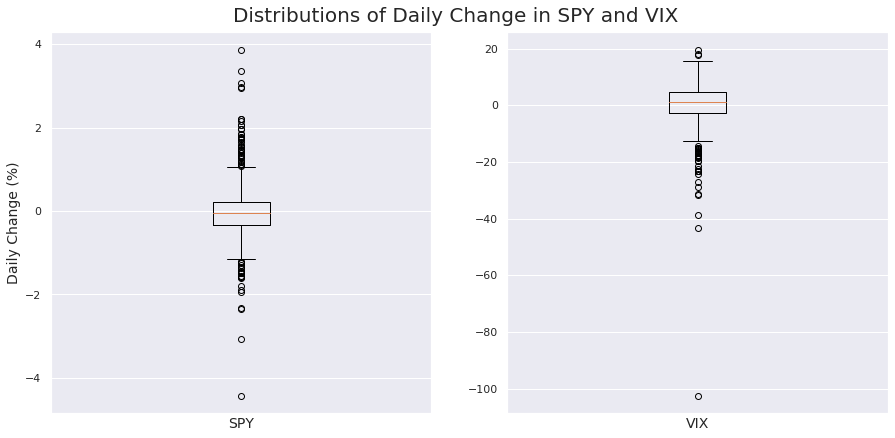

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].boxplot(markets.Daily_Perc)
ax[0].set_xlabel("SPY", fontsize=14)
ax[0].set_xticks([])
ax[1].boxplot(markets.vix_Daily_Perc)
ax[1].set_xlabel("VIX", fontsize=14)
ax[1].set_xticks([])
ax[0].set_ylabel("Daily Change (%)", fontsize=14)
fig.suptitle("Distributions of Daily Change in SPY and VIX", fontsize=20, y=.93)

fig.savefig('figs/boxplot_spy_vix.png', dpi=200)

The VIX change appears to be sligthly skewed, with at least one obvious outlier.

## Merging the Datasets

We know that approval polls are not published every day, and the markets are not open on weekends/holidays, so we have more tweet count observations than approval measures or market changes:

In [33]:
print("Tweet count observations:", len(tweet_counts))
print("Approval rating observations:", len(approval))
print("Market change observations:", len(markets))

Tweet count observations: 1026
Approval rating observations: 881
Market change observations: 714


We do not want to throw away tweet count observations, so we will merge with a left join to keep all the tweet counts. The missing approval and financial data will be NaN (for now).

In [34]:
tmp = pd.merge(tweet_counts, approval, on="date", how="left")

In [35]:
merged = pd.merge(tmp, markets, on="date", how="left")

We also noticed that the approval data only begins in March 2017. We determined we could not reliably impute two months of approval ratings, so we will only model data from 2017-03-02 onward.

In [36]:
print("Earliest tweet count:", tweet_counts.date.min())
print("Earliest approval rating:", approval.date.min())
print("Earliestt market change:", markets.date.min())

Earliest tweet count: 2017-01-01 00:00:00
Earliest approval rating: 2017-03-02 00:00:00
Earliestt market change: 2017-01-03 00:00:00


In [37]:
merged.drop(merged.index[merged.date < pd.to_datetime("2017-03-02")],
            inplace=True)
merged.drop("Date", axis=1, inplace=True)  # extra Date column

In [38]:
display(merged.head())

,date,tweet_count,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,Open,High,...,Intraday_Perc,vix_Open,vix_High,vix_Low,vix_Close,vix_Change,vix_Daily_Perc,vix_Intraday,Weekday,Season
60,2017-03-02,1,44.164797,48.814171,39.515424,47.590546,52.241763,42.939329,2394.750000,2394.750000,...,0.608835,12.43,12.71,11.32,11.81,0.62,4.987932,1.39,3.0,spring
61,2017-03-03,13,43.902260,48.675100,39.129430,49.856540,54.372810,45.340270,2380.919922,2383.889893,...,0.357005,11.96,11.97,10.94,10.96,1.00,8.361204,1.03,4.0,spring
62,2017-03-04,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,2017-03-05,3,43.936930,48.763720,39.110130,49.726230,54.272490,45.179980,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,2017-03-06,4,43.992985,48.685735,39.300240,49.576445,54.080370,45.072520,2375.229980,2378.800049,...,0.455538,11.59,11.72,11.06,11.24,0.35,3.019845,0.66,0.0,spring


## Imputing Missing Data

In [39]:
display(merged.isnull().sum())

date                     0
tweet_count              0
approve_estimate        98
approve_hi              98
approve_lo              98
disapprove_estimate     98
disapprove_hi           98
disapprove_lo           98
Open                   299
High                   299
Low                    299
Close                  299
Volume                 299
Change                 299
Daily_Perc             299
Intraday               299
Intraday_Perc          299
vix_Open               299
vix_High               299
vix_Low                299
vix_Close              299
vix_Change             299
vix_Daily_Perc         299
vix_Intraday           299
Weekday                299
Season                 299
dtype: int64

We thought carefully about how to impute each column with missing data.

#### Approval Ratings

- Approval/disapproval on days without polls is likely comparable to the days around it. This is supported by [fivethirtyeight's model implementation](https://fivethirtyeight.com/features/how-were-tracking-donald-trumps-approval-ratings/) which uses local smoothing to reduce noise. Since we are imputing the outcome of that model, the chance of large movements on the days without data is low. We will interpolate linearly.

#### Market Data

- The open/close price of each index on days when the market is closed must be the same as the previous close price. We will interpolate by using the previous value.
- The change in price is by definition 0; we believe zero-filling these values is reasonable:
    - The non-null daily changes are distributed about 0, so the value itself is not an outlier (see the scatter matrix)
    - We want to examine whether market movement predicts tweet frequency, so we do not want to attribute tweets to variance in market movement when there is none. This would be the case if we imputed non-zero values on these days.
- Trade volume cannot be 0 (it is usually on the order of billions), but there appears to be little day-to-day correlation between volume (see plot below). Thus we will use the overall mean.
    
#### Other

- Weekday and season are objective and must be calculated from the date. They are only null because they came from the market dataset.

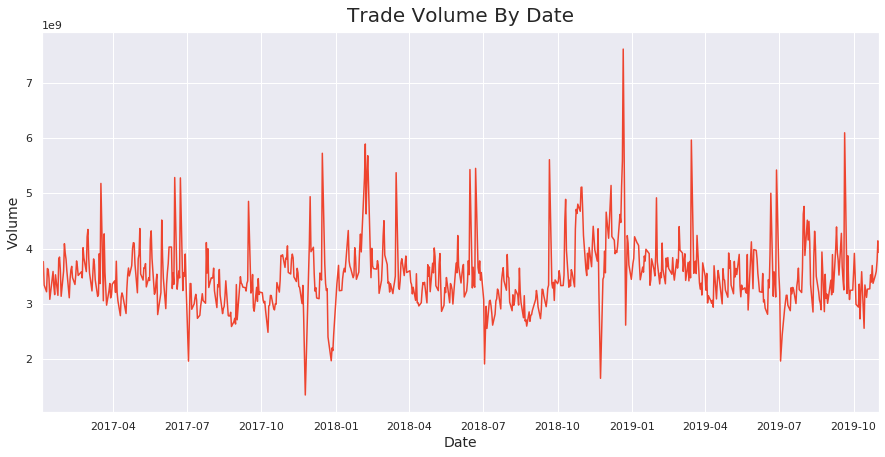

In [40]:
xmin, xmax = markets.date.min(), markets.date.max()

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(markets.date, markets.Volume, color=c_or)
ax.set_title("Trade Volume By Date", fontsize=20, y=1.01)
ax.set_xlabel('Date', fontsize=14)
ax.set_xlim([xmin, xmax])
ax.set_ylabel("Volume", fontsize=14);

fig.savefig('figs/plot_tradevol_date.png', dpi=200)

In [41]:
def _season_from_month(month):
    months = 2 * ["winter"] + 3 * ["spring"] \
        + 3 * ["summer"] + 3 * ["fall"] + ["winter"]
    return months[month - 1]

In [42]:
data = merged.copy()
data.Season = data.date.dt.month.apply(_season_from_month)
data.Weekday = data.date.dt.weekday

for column in data:
    if column == "Season" or column == "Weekday":
        continue  # skip to next column
        
    if column.startswith("approve") or column.startswith("disapprove"):
        data[column] = data[column].interpolate("linear")
        
    elif "Close" in column:
        data[column] = data[column].ffill()
        
    elif "Open" in column:
        # to impute opening values, with the previous day's close,
        # we must forward fill the corresponding close column,
        # BUT ONLY CHANGE THE VALUES FOR THE MISSSING ROWS
        close_name = column.replace("Open", "Close")
        ffilled_close = data[close_name].ffill()  # imputed market-close values
        nan_idx = data[column].isnull()  # index of market-open NaNs
        data.loc[nan_idx, column] = ffilled_close[nan_idx] # set missing opens to imputed close
        
    elif "High" in column or "Low" in column:
        # do the same for high and low (use previous day's close)
        close_name = column.replace("High", "Close").replace("Low", "Close")
        nan_idx = data[column].isnull()
        ffilled_close = data[close_name].ffill()
        data.loc[nan_idx, column] = ffilled_close[nan_idx]
        
    elif column == "Volume":
        nan_idx = data[column].isnull()
        data.loc[nan_idx, column] = data[column].mean()  # fill NaNs with mean
        
    else:
        data[column] = data[column].fillna(0)
        

In [43]:
data.isnull().sum()

date                   0
tweet_count            0
approve_estimate       0
approve_hi             0
approve_lo             0
disapprove_estimate    0
disapprove_hi          0
disapprove_lo          0
Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
Change                 0
Daily_Perc             0
Intraday               0
Intraday_Perc          0
vix_Open               0
vix_High               0
vix_Low                0
vix_Close              0
vix_Change             0
vix_Daily_Perc         0
vix_Intraday           0
Weekday                0
Season                 0
dtype: int64

In [44]:
display(data.sample(10))

,date,tweet_count,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,Open,High,...,Intraday_Perc,vix_Open,vix_High,vix_Low,vix_Close,vix_Change,vix_Daily_Perc,vix_Intraday,Weekday,Season
460,2018-04-10,6,40.606160,45.302620,35.90969,53.353610,57.638730,49.06849,2638.409912,2665.449951,...,1.124538,20.510000,21.680000,20.240000,20.469999,0.040001,0.195032,1.440000,1,spring
634,2018-10-09,18,42.037220,46.830060,37.24438,52.187240,55.988460,48.38602,2882.510010,2894.830078,...,0.713269,16.120001,17.490000,15.270000,15.950000,0.170001,1.054597,2.220000,1,fall
889,2019-06-22,20,42.601380,47.108290,38.09446,52.991700,57.713470,48.26994,2950.459961,2950.459961,...,0.000000,15.400000,15.400000,15.400000,15.400000,0.000000,0.000000,0.000000,5,summer
275,2017-10-05,10,38.812370,43.076410,34.54833,55.614810,59.474410,51.75522,2540.860107,2552.510010,...,0.491565,9.480000,9.620000,9.130000,9.190000,0.290000,3.059072,0.490000,3,fall
667,2018-11-11,6,42.083364,46.682877,37.48385,52.526963,56.228907,48.82502,2781.010010,2781.010010,...,0.000000,17.360001,17.360001,17.360001,17.360001,0.000000,0.000000,0.000000,6,fall
420,2018-03-01,6,40.596260,45.902190,35.29032,54.119980,59.254130,48.98583,2715.219971,2730.889893,...,2.623728,19.959999,25.299999,19.570000,22.469999,-2.510000,-12.575151,5.729999,3,spring
628,2018-10-03,16,41.876780,46.322460,37.43110,52.649800,56.336730,48.96286,2931.689941,2939.860107,...,0.631035,11.660000,12.140000,11.340000,11.610000,0.050000,0.428816,0.800000,2,fall
917,2019-07-20,31,42.697118,47.210125,38.18411,52.419067,56.578310,48.25982,2976.610107,2976.610107,...,0.000000,14.450000,14.450000,14.450000,14.450000,0.000000,0.000000,0.000000,5,summer
1013,2019-10-24,15,40.566990,44.751040,36.38293,54.595090,59.203900,49.98627,3014.780029,3016.070068,...,0.519114,13.980000,14.340000,13.400000,13.710000,0.270000,1.931330,0.940000,3,fall
87,2017-03-29,4,41.203640,46.081600,36.32568,52.531890,57.801970,47.26182,2356.540039,2363.360107,...,0.442181,11.540000,11.700000,11.030000,11.420000,0.120000,1.039861,0.670000,2,spring


In [45]:
data.to_csv("data/cleaned_data.csv", index=False)

# Compare the Relationship of Markets / Approval and Tweet Count

Now that everything is put together, we can start to plot the relationships between different predictors and our response variable. We hope to see some sort of visual relationship (perhaps linear or poly).

In [46]:
# Load data for this section
full_df = pd.read_csv('data/cleaned_data.csv')
full_df.head()

,date,tweet_count,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,Open,High,...,Intraday_Perc,vix_Open,vix_High,vix_Low,vix_Close,vix_Change,vix_Daily_Perc,vix_Intraday,Weekday,Season
0,2017-03-02,1,44.164797,48.814171,39.515424,47.590546,52.241763,42.939329,2394.750000,2394.750000,...,0.608835,12.43,12.71,11.32,11.81,0.62,4.987932,1.39,3,spring
1,2017-03-03,13,43.902260,48.675100,39.129430,49.856540,54.372810,45.340270,2380.919922,2383.889893,...,0.357005,11.96,11.97,10.94,10.96,1.00,8.361204,1.03,4,spring
2,2017-03-04,7,43.919595,48.719410,39.119780,49.791385,54.322650,45.260125,2383.120117,2383.120117,...,0.000000,10.96,10.96,10.96,10.96,0.00,0.000000,0.00,5,spring
3,2017-03-05,3,43.936930,48.763720,39.110130,49.726230,54.272490,45.179980,2383.120117,2383.120117,...,0.000000,10.96,10.96,10.96,10.96,0.00,0.000000,0.00,6,spring
4,2017-03-06,4,43.992985,48.685735,39.300240,49.576445,54.080370,45.072520,2375.229980,2378.800049,...,0.455538,11.59,11.72,11.06,11.24,0.35,3.019845,0.66,0,spring


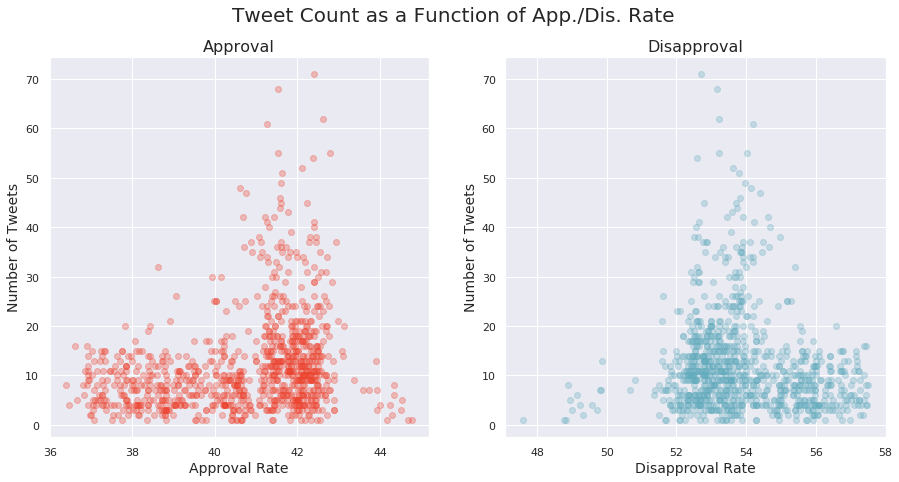

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(full_df['approve_estimate'], full_df['tweet_count'],  alpha=0.3, color=c_or)
ax[1].scatter(full_df['disapprove_estimate'], full_df['tweet_count'], alpha=0.3, color=c_blue)
ax[0].set_xlabel('Approval Rate', fontsize=14)
ax[0].set_ylabel('Number of Tweets', fontsize=14)
ax[0].set_title('Approval', fontsize=16)
ax[1].set_xlabel('Disapproval Rate', fontsize=14)
ax[1].set_ylabel('Number of Tweets', fontsize=14)
ax[1].set_title('Disapproval', fontsize=16)

fig.suptitle('Tweet Count as a Function of App./Dis. Rate', fontsize=20);

fig.savefig('figs/tweet_count_by_appdis.png', dpi=200)

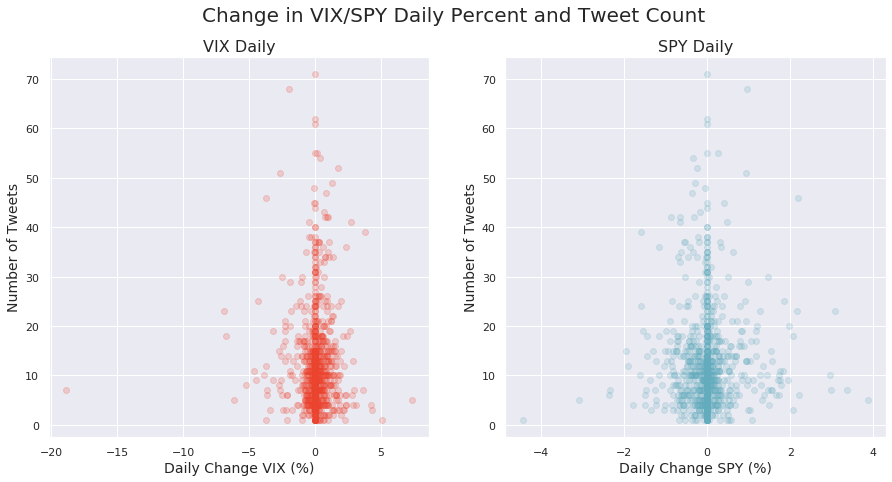

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(full_df['vix_Change'], full_df['tweet_count'], alpha=0.2, color=c_or)
ax[1].scatter(full_df['Daily_Perc'], full_df['tweet_count'], alpha=0.2, color=c_blue)
ax[0].set_xlabel('Daily Change VIX (%)', fontsize=14)
ax[0].set_ylabel('Number of Tweets', fontsize=14)
ax[0].set_title('VIX Daily', fontsize=16)
ax[1].set_xlabel('Daily Change SPY (%)', fontsize=14)
ax[1].set_ylabel('Number of Tweets', fontsize=14)
ax[1].set_title('SPY Daily', fontsize=16)

fig.suptitle('Change in VIX/SPY Daily Percent and Tweet Count', fontsize=20);

fig.savefig('figs/tweet_count_by_vixspy.png', dpi=200)

Look at the charts above, there doesn’t seem to be any strong pattern relating market value or market sentiment to the frequency in which Trump tweets. There are some obvious outliers in SPY and VIX shown, those extremes don’t seem to impact frequency. 

In regards to the polling rate, there does seem to be something kind of showing up. When his approval rate heads toward the higher rank, he does tweet more frequently. But, it we would have liked to see something more stand out. 

One option to improving these graphs would be to apply a hue that associates each tweet with a particular tweet theme or topic.  With that, possible clusters might arise, which could provide more input on how to proceed. Going forward, we will attempt to assign each tweet to a topic. 

Furthermore, if we can manage to create topic categories for each tweet, we might be able to adjust our ultimate project question. It might be possible to predict the topic he will tweet in addition to the frequency. 

# Explore Trump's Word Choice in his Tweets

Here we will explore the specific words that Trump chooses to use when tweeting. The goal is to get a word count and to possibly assign certain themes to tweets related to the market, approval rating, tradewar or other larger themes. Perhaps with this information we will be able to expand beyond predicting Trump's tweet frequency, but also predict the type of tweet he might release. 


After importing the required libraries, and downloading the stopwords for filtering out needless words, its time to get to the data.

In [50]:
# Import tweet archive and produce a dataframe
tweet_df_og = pd.read_csv('data/tweet_archive_raw.csv')
tweet_df_og.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,KENTUCKY! #KYGov Get out today and VOTE for @...,11-05-2019 20:42:10,8141.0,24368,false,1.191818e+18
1,Twitter for iPhone,Thank you so much CLUB 45. You are truly Great...,11-05-2019 18:58:07,11893.0,42053,false,1.191792e+18
2,Twitter for iPhone,RT @Club45USA: Club 45 on NBC Today Show. Show...,11-05-2019 18:56:03,5123.0,0,true,1.191791e+18
3,Twitter for iPhone,KENTUCKY! Get out today and VOTE for @MattBev...,11-05-2019 17:19:46,10589.0,31281,false,1.191767e+18
4,Twitter for iPhone,RT @GOPChairwoman: If you want to defeat the r...,11-05-2019 17:15:42,6400.0,0,true,1.191766e+18


It appears that tweets have a lot of puncuation and horrible use of capitalization. It will be easier to work with if we remove the caps and non-alpha characters.

In [51]:
tweets = []

# Take each observation in the text column, convert to string and adjust
for tweet in tweet_df_og['text']:
    tweet = str(tweet)
    tweet_one = tweet.translate(str.maketrans('', '', string.punctuation))
    tweets.append(tweet_one.lower())
    
tweet_df_og['text'] = tweets

Let's check that it worked, and see if there are any other problems that need to be addressed.

In [52]:
tweet_df_og.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,kentucky kygov get out today and vote for mat...,11-05-2019 20:42:10,8141.0,24368,false,1.191818e+18
1,Twitter for iPhone,thank you so much club 45 you are truly great ...,11-05-2019 18:58:07,11893.0,42053,false,1.191792e+18
2,Twitter for iPhone,rt club45usa club 45 on nbc today show showing...,11-05-2019 18:56:03,5123.0,0,true,1.191791e+18
3,Twitter for iPhone,kentucky get out today and vote for mattbevin...,11-05-2019 17:19:46,10589.0,31281,false,1.191767e+18
4,Twitter for iPhone,rt gopchairwoman if you want to defeat the rad...,11-05-2019 17:15:42,6400.0,0,true,1.191766e+18


It worked, so now we just need to take each tweet, split to words and then create a dictionary of words that aren't in stop_words. 

In [53]:
word_dict = {}
stop_words = stopwords.words("english")
stop_words += ['realdonaldtrump', 'amp', 'rt', 'twitter']

# Grab each tweet
for tweet in tweet_df_og['text']:
    
    # Take each word
    for word in tweet.split():
        
        # Exclude stop words from being added to the dictionary
        if word not in stop_words:
            
            # Check if it is in dict, increase by one if yes, add if no
            word_dict[word] = word_dict.get(word, 0) + 1

word_dict

{'kentucky': 63,
 'kygov': 1,
 'get': 1858,
 'today': 1174,
 'vote': 1138,
 'mattbevin': 16,
 'entire': 126,
 'republican': 486,
 'ticket': 32,
 'mississippi': 41,
 'msgov': 1,
 'tatereeves': 5,
 'ticketpolls': 1,
 'open': 279,
 'hours': 97,
 'find': 227,
 'location': 43,
 'httpstco0rnhb4z3hu': 2,
 'thank': 2671,
 'much': 1128,
 'club': 154,
 '45': 27,
 'truly': 254,
 'great': 6019,
 'americans': 367,
 'see': 1029,
 'florida': 305,
 'httpstco0nuayexepn': 1,
 'club45usa': 1,
 'nbc': 302,
 'show': 794,
 'showing': 53,
 'strong': 498,
 'support': 460,
 'president': 2982,
 'danscavino': 99,
 'httpstcorsvqdeahnx': 1,
 'voteonnov5': 1,
 'electionday': 6,
 'polling': 46,
 'belowhttpstco0rnhb4z3hu': 1,
 'gopchairwoman': 86,
 'want': 1027,
 'defeat': 66,
 'radical': 149,
 'left': 293,
 'keepamericagreat': 4,
 'many': 1323,
 'conservative…': 1,
 'good': 1523,
 'start': 289,
 'please': 573,
 'work': 821,
 'hard': 590,
 'final': 98,
 'deal': 795,
 'httpstcoiygebqqiq9': 1,
 'sad': 274,
 'happening'

Everything looks good thus far. Now, let's sort the words by their frequency and then create a CSV for other team members to explore. 

In [54]:
word_freq = pd.Series(word_dict)

word_freq = word_freq.sort_values(ascending=False)

word_freq.to_csv('data/word_freq.csv')

/home/andrew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


## Start Exploring the Data

With the export completed, it is time to use it to create a dataframe to dive a little deeper.

In [55]:
tweet_df = pd.read_csv('word_freq.csv', names=['word', 'freq']).dropna()

# Check how many words we have
print(f'Number of words in dataframe: {tweet_df.shape[0]}')

# Words over 100
words_ovr_100 = tweet_df.loc[tweet_df['freq'] > 100].shape[0]
print(f'\nNumber of words used more than 100 time: {words_ovr_100}')

# Word over 1000
words_ovr_1000 = tweet_df.loc[tweet_df['freq'] > 1000].shape[0]
print(f'\nNumber of words used more than 1000 time: {words_ovr_1000}')


Number of words in dataframe: 64430

Number of words used more than 100 time: 805

Number of words used more than 1000 time: 34


Even after removing the stop words, the total number of words here is too large. With only 38 words being used over 1000 times, that seems like a good place to start.

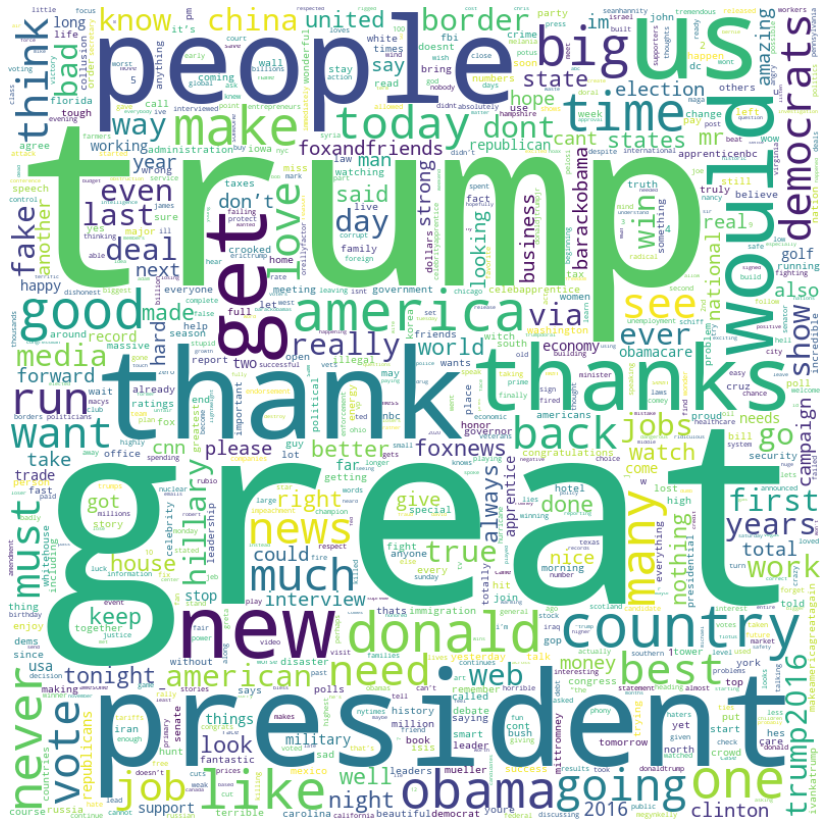

In [71]:
# Created needed tuples for wordcloud
word_tup = [tuple(x) for x in tweet_df.loc[tweet_df['freq'] > 100].values]

# Generate a wordcloud
cloud = WordCloud(max_words=800, background_color='white', width=800, height=800)
cloud = cloud.generate_from_frequencies(dict(word_tup))

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(cloud, interpolation='bilinear')
ax.axis('off');

fig.savefig('figs/tweet_cloud.png', dpi=200)

Even after removing the stop words, there are still too many. Let's try using topic modeling to see if there is more potential there. 

## Topic Modeling

While we weren't able to get a lot of progress toward assigning topics to each tweet by a simple word frequency search, perhaps we will have better luck using some of the additional functionality provided by NLTK and Gensim. If we are able to generate quality topics, then we can assigned an additional column to our dataframe representing the topic of each tweet. This will be required for us to provide any sort of topic predict based on market and/or polling data.

In [72]:
# Import fresh unchanged version of the raw tweets
tweet_df = pd.read_csv('data/tweet_archive_raw.csv')

tweets = []

# Take each observation in the text column, convert to string and adjust
for tweet in tweet_df['text']:
    tweet = str(tweet)
    tweet_one = tweet.translate(str.maketrans('', '', string.punctuation))
    tweets.append(tweet_one.lower())
    
tweet_df['text'] = tweets

In [73]:
stop_words = stopwords.words("english")
stop_words += ['realdonaldtrump', 'amp', 'rt', 'twitter']

# index of rows for 2017 onward
tweet_df.created_at = pd.to_datetime(tweet_df.created_at, errors="coerce")
idx = tweet_df.created_at.dt.year >= 2017

# tweets from 2017 onward
tweets = tweet_df.text.values[idx]
print(f'Number of Tweets since the start of 2017: {len(tweets)}\n')

Number of Tweets since the start of 2017: 12094



In [74]:
# Preprocess by removing stopwords, words without letters/numbers, and URLs
exp = re.compile("[a-zA-Z0-9]")
url_exp = re.compile("http.*")

def pre_process(sentence):
    tokens = word_tokenize(sentence.lower())
    tokens = [i for i in tokens if i not in stop_words]
    return [i for i in tokens if exp.search(i) and not url_exp.match(i)]

Now that we have the pre_processing function setup, it is time to run it and check if an example.

In [75]:
# list of lists of tokens
tokenized = [pre_process(tweet) for tweet in tweets]

# example
print(tokenized[4032])

['congratulations', 'governor', 'mattbevin', 'winning', 'republican', 'primary', 'governor', 'tonight', 'great', 'state', 'kentucky', 'matt', 'fantastic', 'job']


Function is working correct. Now lets makes the nltk corpus, and make sure that the top 20 words seem reasonable with what was observed earlier in the notebook.

In [76]:
# make an nltk corpus for convenience, look at top words
nltk_text = Text(itertools.chain(*tokenized))

print(f'NLTK Generated Frequency: \n{nltk_text.vocab()}')

print(f'\nTop 20 Words from NLTK: \n{nltk_text.vocab().most_common(20)}')

NLTK Generated Frequency: 
<FreqDist with 17121 samples and 178236 outcomes>

Top 20 Words from NLTK: 
[('great', 2370), ('president', 1314), ('people', 1208), ('trump', 1008), ('us', 987), ('democrats', 929), ('country', 878), ('news', 870), ('thank', 814), ('big', 765), ('fake', 755), ('many', 699), ('new', 697), ('border', 695), ('get', 665), ('today', 653), ('would', 634), ('america', 633), ('never', 586), ('time', 578)]


After removing `realdonaldtrump`, `amp` and other words that provided no help in the process, we can see that the collection is similar to what we got above. 

In [77]:
# make vocab (id-word map) and bag-of-words corpus
vocab = Dictionary(tokenized)
corpus = [vocab.doc2bow(doc) for doc in tokenized]

# each corpus item represents a tweet
# as a list of tuples mapping word ID to count (in that tweet)
print(corpus[2949])

[(23, 1), (74, 1), (122, 1), (155, 1), (205, 1), (466, 1), (1035, 1), (2305, 1), (2831, 1), (4406, 1), (7828, 1)]


In [78]:
# instantiate LDA model from corpus with specificed number of topics
lda = LdaMulticore(corpus, id2word=vocab, num_topics=20, passes=10, random_state=42)

In [79]:
lda.print_topics()

[(0,
  '0.012*"new" + 0.011*"president" + 0.007*"great" + 0.007*"trump" + 0.007*"big" + 0.006*"thank" + 0.006*"country" + 0.005*"people" + 0.005*"economy" + 0.005*"ever"'),
 (1,
  '0.011*"great" + 0.008*"us" + 0.008*"many" + 0.007*"people" + 0.006*"china" + 0.006*"thank" + 0.006*"one" + 0.005*"president" + 0.005*"like" + 0.005*"get"'),
 (2,
  '0.022*"great" + 0.015*"president" + 0.008*"country" + 0.006*"people" + 0.006*"new" + 0.005*"would" + 0.005*"congratulations" + 0.005*"trump" + 0.005*"good" + 0.005*"court"'),
 (3,
  '0.022*"president" + 0.016*"trump" + 0.008*"people" + 0.007*"never" + 0.007*"big" + 0.006*"call" + 0.005*"schiff" + 0.005*"democrats" + 0.005*"collusion" + 0.004*"donald"'),
 (4,
  '0.027*"great" + 0.013*"crime" + 0.010*"vote" + 0.009*"military" + 0.009*"endorsement" + 0.008*"strong" + 0.008*"people" + 0.007*"vets" + 0.007*"borders" + 0.007*"get"'),
 (5,
  '0.018*"great" + 0.012*"american" + 0.011*"thank" + 0.008*"north" + 0.008*"happy" + 0.008*"people" + 0.007*"new" 

We can see each word and the weight, but this is hard to read. It is best to create some helper functions and work on formatting the output. Hopefully by the end of this we will start to see the formation of strong topics that we can use for predictions.

In [80]:
# helpers for interpreting LDA topics

def max_topic(topics):
    """
    Given a list of tuples (topic_id, weight),
    return the topic_id with the highest weight
    """
    return max(topics, key=lambda x: x[0])[0]

def top_terms_from_topic(topic_id, num_terms=5):
    terms = lda.get_topic_terms(topic_id, num_terms)
    return [vocab[i[0]] for i in terms]

In [81]:
for tweet_id in np.random.randint(0, len(tweets), 10):
    print(f'Tweet: {tweets[tweet_id]}')
    print(f'\nLDA: {lda[corpus[tweet_id]]}')
    
    max_topic_id = max_topic(lda[corpus[tweet_id]])
    
    print(f'\nTop terms from Tweet: {top_terms_from_topic(max_topic_id, 10)}')
    print('--------------------------------------\n')

Tweet: tainted no very dishonest fbi “agent’s role in clinton probe under review” led clinton email probe foxandfriends  clinton money going to wife of another fbi agent in charge

LDA: [(0, 0.6808725), (13, 0.27820352)]

Top terms from Tweet: ['hunt', 'witch', 'fbi', 'hillary', 'trump', 'clinton', 'collusion', 'campaign', 'crooked', 'many']
--------------------------------------

Tweet: the united states has spent eight trillion dollars fighting and policing in the middle east thousands of our great soldiers have died or been badly wounded millions of people have died on the other side going into the middle east is the worst decision ever made

LDA: [(9, 0.96605855)]

Top terms from Tweet: ['would', 'democrats', 'get', 'president', 'never', 'even', 'states', 'house', 'united', 'like']
--------------------------------------

Tweet: just arrived in taormina with flotus melania g7summit usa🇺🇸 httpstcol7axolkbik

LDA: [(2, 0.15447824), (8, 0.1810991), (16, 0.29375136), (19, 0.25614443)]



After working through this multiple times, we did manage to find a few coherent topics. However, most seemed to be strange associations with random words. The full 20 topics and their top-weighted words are copied below this cell. Here are some example that we tried to associate with a topic that we could categorize. 

The witch hunt

`0.014*"hunt" + 0.013*"witch" + 0.011*"fbi" + 0.009*"hillary" + 0.009*"trump" + 0.008*"clinton" + 0.008*"collusion" + 0.007*"campaign" + 0.007*"crooked" + 0.006*"many"`

National security? 

`0.027*"great" + 0.013*"crime" + 0.010*"vote" + 0.009*"military" + 0.009*"endorsement" + 0.008*"strong" + 0.008*"people" + 0.007*"vets" + 0.007*"borders" + 0.007*"get"`

Possibly related to trade war 

`0.018*"us" + 0.013*"trade" + 0.012*"china" + 0.007*"market" + 0.007*"years" + 0.007*"country" + 0.007*"tariffs" + 0.006*"democrats" + 0.006*"economy" + 0.006*"border"`

Looking at the complete top 20 topics below, we can see that many of them don't really make sense. They also all seem to share a lot of the same words, signaling that he only uses the same 25 words or so... a lot. Overall, this approach doesn't appear worthwhile. Sometime EDA shows us where not to go, just as much as it shows us where to go. 


In [82]:
[(0,   '0.012*"new" + 0.011*"president" + 0.007*"great" + 0.007*"trump" + 0.007*"big" + 0.006*"thank" + 0.006*"country" + 0.005*"people" + 0.005*"economy" + 0.005*"ever"'),  
(1,   '0.011*"great" + 0.008*"us" + 0.008*"many" + 0.007*"people" + 0.006*"china" + 0.006*"thank" + 0.006*"one" + 0.005*"president" + 0.005*"like" + 0.005*"get"'),  
(2,   '0.022*"great" + 0.015*"president" + 0.008*"country" + 0.006*"people" + 0.006*"new" + 0.005*"would" + 0.005*"congratulations" + 0.005*"trump" + 0.005*"good" + 0.005*"court"'),  
(3,   '0.022*"president" + 0.016*"trump" + 0.008*"people" + 0.007*"never" + 0.007*"big" + 0.006*"call" + 0.005*"schiff" + 0.005*"democrats" + 0.005*"collusion" + 0.004*"donald"'),  
(4,   '0.027*"great" + 0.013*"crime" + 0.010*"vote" + 0.009*"military" + 0.009*"endorsement" + 0.008*"strong" + 0.008*"people" + 0.007*"vets" + 0.007*"borders" + 0.007*"get"'), 
(5,   '0.018*"great" + 0.012*"american" + 0.011*"thank" + 0.008*"north" + 0.008*"happy" + 0.008*"people" + 0.007*"new" + 0.006*"korea" + 0.006*"whitehouse" + 0.006*"today"'), 
(6,   '0.010*"great" + 0.008*"border" + 0.008*"today" + 0.007*"job" + 0.006*"democrats" + 0.006*"vote" + 0.006*"many" + 0.005*"country" + 0.005*"new" + 0.005*"house"'),  
(7,   '0.018*"us" + 0.013*"trade" + 0.012*"china" + 0.007*"market" + 0.007*"years" + 0.007*"country" + 0.007*"tariffs" + 0.006*"democrats" + 0.006*"economy" + 0.006*"border"'), 
(8,   '0.011*"democrats" + 0.010*"russia" + 0.008*"obama" + 0.008*"people" + 0.007*"president" + 0.006*"trump" + 0.005*"election" + 0.005*"would" + 0.004*"american" + 0.004*"house"'),  
(9,   '0.009*"would" + 0.009*"democrats" + 0.008*"get" + 0.007*"president" + 0.006*"never" + 0.006*"even" + 0.005*"states" + 0.005*"house" + 0.005*"united" + 0.005*"like"'),  
(10,   '0.012*"president" + 0.010*"comey" + 0.009*"trump" + 0.007*"james" + 0.005*"thank" + 0.005*"right" + 0.005*"way" + 0.004*"fbi" + 0.004*"going" + 0.004*"great"'),  
(11,   '0.014*"great" + 0.008*"us" + 0.007*"president" + 0.007*"trump" + 0.006*"big" + 0.006*"china" + 0.005*"people" + 0.004*"north" + 0.004*"time" + 0.004*"deal"'),  
(12,   '0.017*"great" + 0.011*"tax" + 0.010*"korea" + 0.010*"people" + 0.010*"north" + 0.009*"us" + 0.006*"security" + 0.006*"cuts" + 0.006*"many" + 0.006*"military"'),  
(13,   '0.014*"hunt" + 0.013*"witch" + 0.011*"fbi" + 0.009*"hillary" + 0.009*"trump" + 0.008*"clinton" + 0.008*"collusion" + 0.007*"campaign" + 0.007*"crooked" + 0.006*"many"'),  
(14,   '0.017*"news" + 0.016*"fake" + 0.013*"border" + 0.010*"wall" + 0.009*"country" + 0.009*"people" + 0.006*"media" + 0.006*"mexico" + 0.006*"cnn" + 0.006*"must"'),  
(15,   '0.017*"thank" + 0.014*"great" + 0.007*"new" + 0.007*"day" + 0.006*"women" + 0.006*"today" + 0.006*"fbi" + 0.006*"trump" + 0.005*"honor" + 0.005*"ohio"'),  
(16,   '0.031*"great" + 0.018*"media" + 0.017*"america" + 0.016*"fake" + 0.016*"news" + 0.012*"make" + 0.008*"big" + 0.008*"people" + 0.007*"thank" + 0.006*"working"'),  
(17,   '0.010*"iran" + 0.007*"us" + 0.007*"states" + 0.006*"much" + 0.006*"united" + 0.006*"must" + 0.006*"many" + 0.006*"back" + 0.006*"deal" + 0.006*"dollars"'),  
(18,   '0.013*"jobs" + 0.013*"great" + 0.012*"democrats" + 0.008*"trump" + 0.006*"country" + 0.006*"one" + 0.006*"news" + 0.005*"time" + 0.005*"never" + 0.005*"want"'),  
(19,   '0.021*"president" + 0.015*"great" + 0.011*"whitehouse" + 0.008*"trump" + 0.008*"today" + 0.008*"prime" + 0.008*"minister" + 0.007*"honor" + 0.006*"flotus" + 0.006*"american"')]

[(0,
  '0.012*"new" + 0.011*"president" + 0.007*"great" + 0.007*"trump" + 0.007*"big" + 0.006*"thank" + 0.006*"country" + 0.005*"people" + 0.005*"economy" + 0.005*"ever"'),
 (1,
  '0.011*"great" + 0.008*"us" + 0.008*"many" + 0.007*"people" + 0.006*"china" + 0.006*"thank" + 0.006*"one" + 0.005*"president" + 0.005*"like" + 0.005*"get"'),
 (2,
  '0.022*"great" + 0.015*"president" + 0.008*"country" + 0.006*"people" + 0.006*"new" + 0.005*"would" + 0.005*"congratulations" + 0.005*"trump" + 0.005*"good" + 0.005*"court"'),
 (3,
  '0.022*"president" + 0.016*"trump" + 0.008*"people" + 0.007*"never" + 0.007*"big" + 0.006*"call" + 0.005*"schiff" + 0.005*"democrats" + 0.005*"collusion" + 0.004*"donald"'),
 (4,
  '0.027*"great" + 0.013*"crime" + 0.010*"vote" + 0.009*"military" + 0.009*"endorsement" + 0.008*"strong" + 0.008*"people" + 0.007*"vets" + 0.007*"borders" + 0.007*"get"'),
 (5,
  '0.018*"great" + 0.012*"american" + 0.011*"thank" + 0.008*"north" + 0.008*"happy" + 0.008*"people" + 0.007*"new" 

# Model Selection

Now that we have decided to stick strictly to predicting Tweet frequency, and leave the idea of predicting the topic behind, let’s explore different models. Given that this is a quantitative outcome, we will be using the $R^2$ score to compare different models. First me must import that data and standardize the features for certain models to come.

In [83]:
data = pd.read_csv("data/cleaned_data.csv")

data.date = pd.to_datetime(data.date)
data = pd.get_dummies(data, columns=["Season", "Weekday"], drop_first=True)

data.head()

,date,tweet_count,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,Open,High,...,vix_Intraday,Season_spring,Season_summer,Season_winter,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,2017-03-02,1,44.164797,48.814171,39.515424,47.590546,52.241763,42.939329,2394.750000,2394.750000,...,1.39,1,0,0,0,0,1,0,0,0
1,2017-03-03,13,43.902260,48.675100,39.129430,49.856540,54.372810,45.340270,2380.919922,2383.889893,...,1.03,1,0,0,0,0,0,1,0,0
2,2017-03-04,7,43.919595,48.719410,39.119780,49.791385,54.322650,45.260125,2383.120117,2383.120117,...,0.00,1,0,0,0,0,0,0,1,0
3,2017-03-05,3,43.936930,48.763720,39.110130,49.726230,54.272490,45.179980,2383.120117,2383.120117,...,0.00,1,0,0,0,0,0,0,0,1
4,2017-03-06,4,43.992985,48.685735,39.300240,49.576445,54.080370,45.072520,2375.229980,2378.800049,...,0.66,1,0,0,0,0,0,0,0,0


While creating the train / test split, we decided it would be best to stratify over years. We noticed that Trump has started to tweet more frequently since the impeachment investigation has started, and we want that to not impact our results. Even though the increase in the past 5-6 months have been mostly retweets, they will be counted toward the overall frequency for that day. 

In [84]:
# Generate train / test split
splits = train_test_split(data.loc[:, ~data.columns.isin(["tweet_count", "date"])],
                          data.tweet_count, data.date, test_size=0.2, 
                          random_state=17, shuffle=True,
                          stratify=data.date.dt.year)

X_train, X_test, y_train, y_test, date_train, date_test = splits

In [85]:
# Column names for use throughout the process
cols = ["approve_estimate", "approve_hi", "approve_lo", "disapprove_estimate",
        "disapprove_hi", "disapprove_lo", "Open", "High", "Low", "Close",
        "Volume", "Change", "Daily_Perc", "Intraday", "Intraday_Perc", "vix_Open",
        "vix_Close", "vix_Change", "vix_Daily_Perc", "vix_Intraday"]

In [86]:
# Standardize helper function
def standardize(train, test, columns=[]):
    train_out = train.copy()
    test_out = test.copy()
    ss = StandardScaler()
    train_out[columns] = ss.fit_transform(train[columns])
    test_out[columns] = ss.transform(test[columns])
    return train_out, test_out

In [87]:
X_train, X_test = standardize(X_train, X_test, cols)

In [88]:
X_train.describe()

,approve_estimate,approve_hi,approve_lo,disapprove_estimate,disapprove_hi,disapprove_lo,Open,High,Low,Close,...,vix_Intraday,Season_spring,Season_summer,Season_winter,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
count,7.720000e+02,7.720000e+02,7.720000e+02,7.720000e+02,7.720000e+02,7.720000e+02,7.720000e+02,7.720000e+02,7.720000e+02,7.720000e+02,...,7.720000e+02,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000
mean,-1.999696e-15,2.185931e-17,1.174507e-15,-3.788564e-15,-4.032468e-16,-4.628170e-15,-5.159948e-16,4.134574e-16,-1.889105e-15,-1.171630e-15,...,1.461123e-16,0.268135,0.286269,0.190415,0.139896,0.148964,0.145078,0.138601,0.148964,0.147668
std,1.000648e+00,1.000648e+00,1.000648e+00,1.000648e+00,1.000648e+00,1.000648e+00,1.000648e+00,1.000648e+00,1.000648e+00,1.000648e+00,...,1.000648e+00,0.443275,0.452310,0.392883,0.347104,0.356284,0.352407,0.345754,0.356284,0.355001
min,-2.427692e+00,-2.367049e+00,-2.434708e+00,-4.090408e+00,-3.591051e+00,-4.385874e+00,-1.961534e+00,-1.995340e+00,-1.923534e+00,-1.963531e+00,...,-6.737582e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.982941e-01,-8.448278e-01,-8.120668e-01,-7.100474e-01,-7.035207e-01,-6.284867e-01,-7.915731e-01,-8.082315e-01,-7.821514e-01,-7.936173e-01,...,-6.737582e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.604375e-01,3.505963e-01,3.367109e-01,-2.101329e-01,-2.390422e-01,-1.069063e-01,1.023323e-01,1.202219e-01,9.242534e-02,1.081061e-01,...,-1.947536e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.943599e-01,7.719697e-01,8.145169e-01,6.988581e-01,6.956254e-01,7.107427e-01,8.315594e-01,8.518314e-01,8.368138e-01,8.337285e-01,...,2.210856e-01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.347053e+00,2.331743e+00,2.310226e+00,2.320394e+00,2.563299e+00,2.258132e+00,1.923254e+00,1.876221e+00,1.981490e+00,1.927051e+00,...,1.400169e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


While not an exact mean of zero, it is close enough. Everything appears to have been standardized.

## Exploring OLS
The first logical model to attempt is standard linear regression. Hopefully we have some sort of linear relationship, otherwise we will have to attempt adding polynomial features to account for a non-linear relationship.

In [89]:
# Build and fit model
model = LinearRegression().fit(X_train, y_train)

# Report scores
print('Simple OLS model R^2 scores using all predictors:')
print(f'Training Data: \t{model.score(X_train, y_train)}')
print(f'Testing Data: \t{model.score(X_test, y_test)}')

Simple OLS model R^2 scores using all predictors:
Training Data: 	0.34689627622961605
Testing Data: 	0.3978383159594514


These scores aren’t very good. The next step is to explore the residuals to check for things like heteroscedasticity or other problems.

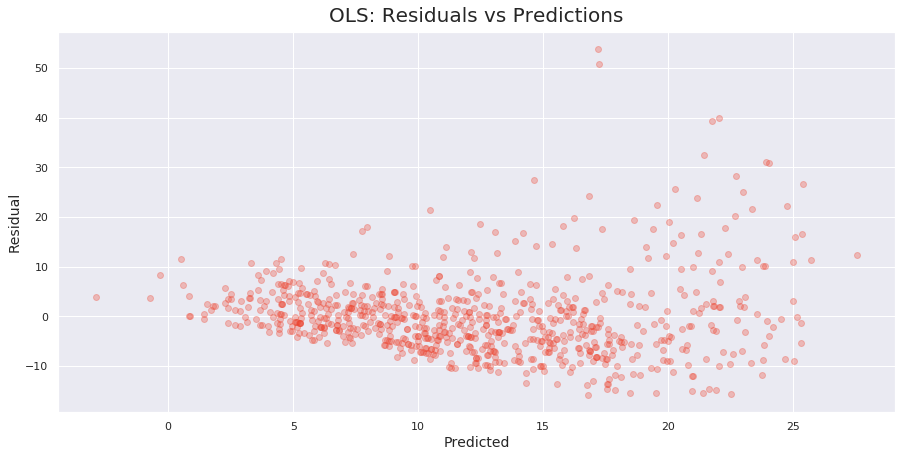

In [90]:
# Get prediction and plot residuals
ypred = model.predict(X_train)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.scatter(ypred, y_train - ypred, alpha=0.3, color=c_or)
ax.set_title("OLS: Residuals vs Predictions", fontsize=20, y=1.01)
ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("Residual", fontsize=14);

fig.savefig('figs/OLS_res_v_pred.png', dpi=200)

This is not what we want to see. Our hope would be for the plot to show no sort of pattern, but it clearly displays a non-random pattern. We might be able to increase the performance by correcting for this problem. Let’s take the log of our outcome variable `tweet_count`.

In [91]:
# Fit new model with log-y
model = LinearRegression().fit(X_train, np.log(y_train))

# Report scores
print('R^2 scores of OLS model using all predictors and log-y:')
print(f'Training Data: \t{model.score(X_train, np.log(y_train))}')
print(f'Testing Data: \t{model.score(X_test, np.log(y_test))}')


R^2 scores of OLS model using all predictors and log-y:
Training Data: 	0.36088640481692075
Testing Data: 	0.3585805948801709


It seems this slightly improved the training score, but reduced the test data score. That isn’t what we wanted to see, but perhaps we can see if we fixed the distribution of the residuals. 

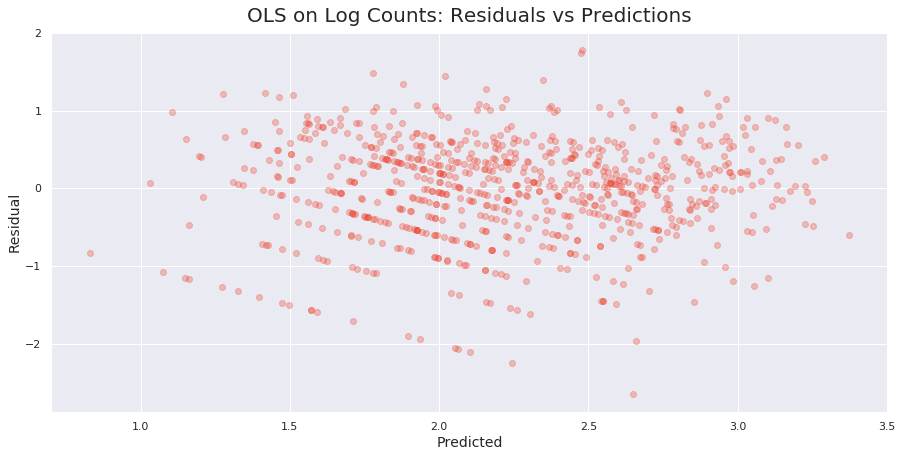

In [92]:
# Get predictions and plot residuals
ypred = model.predict(X_train)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.scatter(ypred, np.log(y_train) - ypred, alpha=0.3, color=c_or)
ax.set_title("OLS on Log Counts: Residuals vs Predictions", fontsize=20, y=1.01)
ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("Residual", fontsize=14);

fig.savefig('figs/OLSlog_res_v_pred.png', dpi=200)

While we corrected the the heteroscedasticity, there are still very clear patterns present. Perhaps this isn’t the best model choice, let’s proceed to trying decision trees with different ensemble methods. 

## Decision Trees
After some thought, we decided to explore non-parametric methods. One that jumped out at us was the decision tree. While we will lose some of the interpretability of these models as we proceed to use bagging, random forest and boosting, there is a kind of a logical reason these might work better. If we are trying to see if Trump tweets more when the market or his approval ratings make big changes, then the A/B slicing nature of a decision tree should manage this rather well. Let’s give it a go. 

### Bagged Decision Trees
Generally better results come from the modified versions of decision trees, so we will skip the simple tree and progress toward bagging. 

In [93]:
depths = (range(2, 11))
Ns = (1, 5, 10, 25, 50, 100)

scores = dict()
bagged_models = dict()

for N in Ns:
    scores[N] = dict(train=[], test=[])
    bagged_models[N] = []
    for depth in depths:
        b = BaggingRegressor(DecisionTreeRegressor(max_depth=depth),
                             n_estimators=N)
        b.fit(X_train, y_train)
        scores[N]["train"].append(b.score(X_train, y_train))
        scores[N]["test"].append(b.score(X_test, y_test))
        bagged_models[N].append(b)

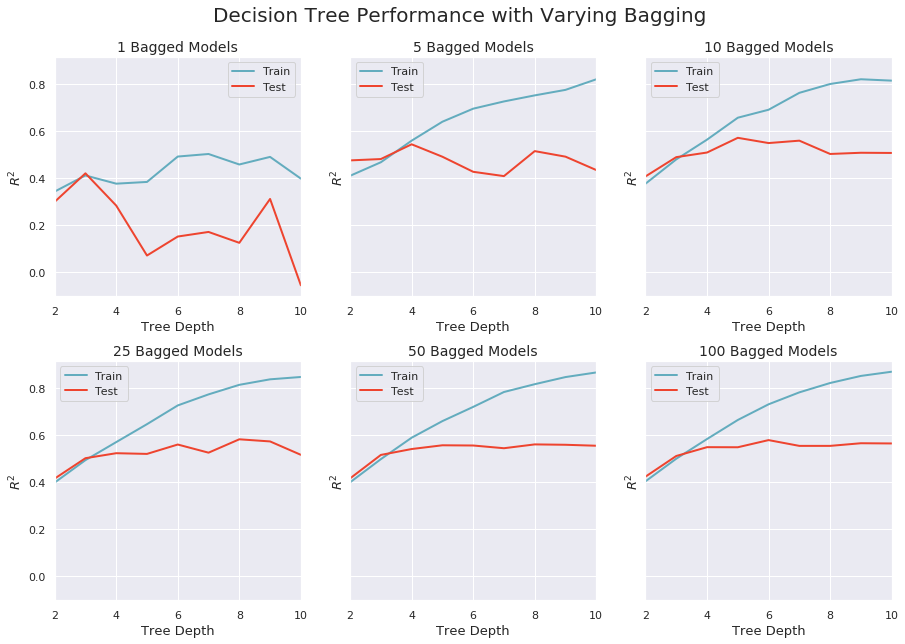

In [95]:
# Plot the different results to compare
axes = [(0,0,1),(0,1,5),(0,2,10),(1,0,25),(1,1,50),(1,2,100)]

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, gridspec_kw={'hspace': 0.27})

for r, c, n in axes:
    ax[r][c].set_title(f"{n} Bagged Models", fontsize=14)
    ax[r][c].plot(depths, scores[n]["train"], label="Train", color=c_blue, lw=2)
    ax[r][c].plot(depths, scores[n]["test"], label="Test", color=c_or, lw=2)
    ax[r][c].set_xlabel("Tree Depth", fontsize=13)
    ax[r][c].set_xlim([2,10])
    ax[r][c].set_ylabel("$R^2$", fontsize=13)
    ax[r][c].legend();

fig.suptitle('Decision Tree Performance with Varying Bagging', fontsize=20, y=0.95);

fig.savefig('figs/bagging_matrix.png', dpi=200)

Based on the graph above, it seems the bagging models are getting better with more iterations. The $R^2$ score on the 25 bagged model seems to be the highest out of any of these, coming in just under 0.6. This is a big improvement over the OLS scores received earlier. 

Let’s plot a large version of this one for the report and to get a better view.

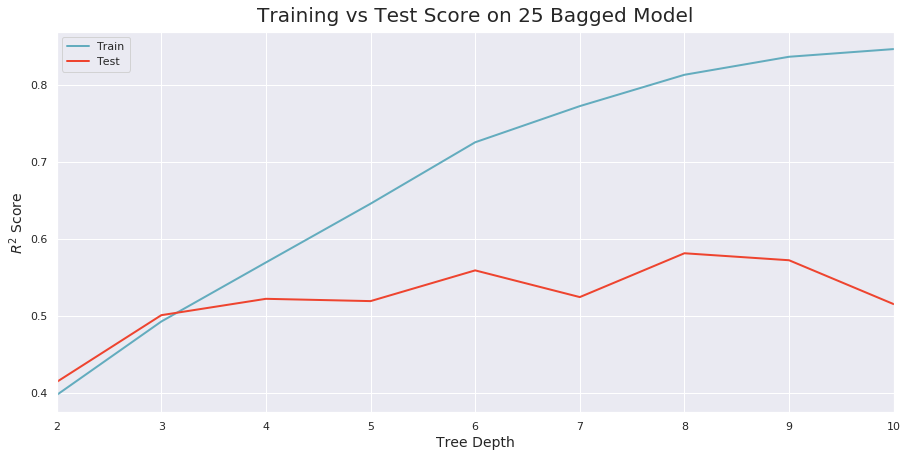

In [96]:
# Plot the performance with different tree depths

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(depths, scores[25]["train"], label="Train", color=c_blue, lw=2)
ax.plot(depths, scores[25]["test"], label="Test", color=c_or, lw=2)
ax.set_title("Training vs Test Score on 25 Bagged Model", fontsize=20, y=1.01)
ax.set_xlabel("Tree Depth", fontsize=14)
ax.set_ylabel("$R^2$ Score", fontsize=14)
ax.set_xlim([2,10])
ax.set_xticks(depths)
ax.legend();

fig.savefig('figs/25bag_full.png')

## Decision Tree Boosting
If the bagging model gives us good performance, we should try a few other ensemble methods to see if we can get an even better score. The next choice is boosting, so we will try ADABoosting.

In [97]:
depths = range(2, 21, 2)

boost_scores_train = []
boost_scores_test = []

for depth in depths:
    base = DecisionTreeRegressor(max_depth=depth)
    boost = AdaBoostRegressor(base, n_estimators=500, learning_rate=0.05)
    boost.fit(X_train, y_train)
    boost_scores_train.append(boost.score(X_train, y_train))
    boost_scores_test.append(boost.score(X_test, y_test))

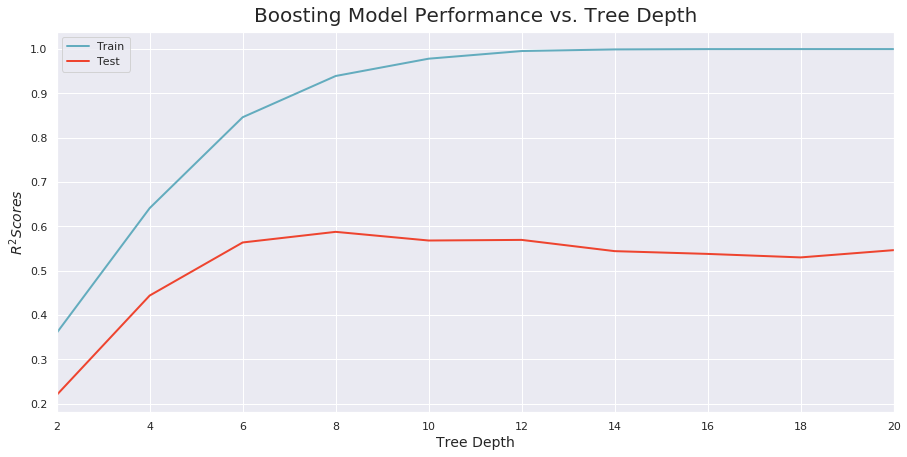

In [98]:
# Plot the performance with different tree depths

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(depths, boost_scores_train, label="Train", lw=2, color=c_blue)
ax.plot(depths, boost_scores_test, label="Test", lw=2, color=c_or)
ax.set_title("Boosting Model Performance vs. Tree Depth", fontsize=20, y=1.01)
ax.set_xlabel("Tree Depth", fontsize=14)
ax.set_ylabel("$R^2 Scores$", fontsize=14)
ax.set_xlim([2,10])
ax.set_xticks(depths)
ax.legend();

fig.savefig('figs/boosting_full.png', dpi=200)

## Random Forests

The boosted decision tree model didn’t generate a lot of progress over the bagging version. One thing that came to us was that the models above might be able to predictor frequency, but it doesn’t ultimately help us answer our main research question. That is, which predicts the frequency best, the market or approval ratings. A possible solution for this is to use a random forest. Given the nature of the design, we can perhaps discover that in absence of the main splitter, another item from the opposite camp of data rises to the top.

It is always useful to try and overcome the shortcomings of greedy algorithms. 

In [102]:
depths = (range(2, 21))
Ns = (1, 5, 10, 25, 50, 100)

rf_scores = dict()
rf_models = dict()

for N in Ns:
    rf_scores[N] = dict(train=[], test=[])
    rf_models[N] = []
    for depth in depths:
        b = RandomForestRegressor(max_depth=depth, n_estimators=N,
                                  max_features=int(np.sqrt(X_train.shape[1])))
        b.fit(X_train, y_train)
        rf_scores[N]["train"].append(b.score(X_train, y_train))
        rf_scores[N]["test"].append(b.score(X_test, y_test))
        rf_models[N].append(b)

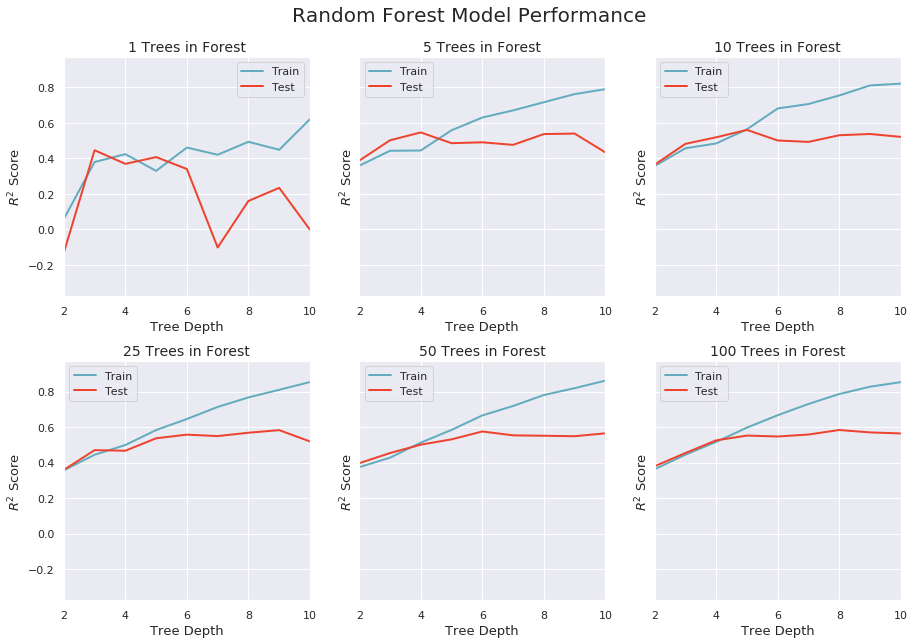

In [103]:
# Plot the different results to compare
axes = [(0,0,1),(0,1,5),(0,2,10),(1,0,25),(1,1,50),(1,2,100)]

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, gridspec_kw={'hspace': 0.27})

for r, c, n in axes:
    ax[r][c].set_title(f"{n} Trees in Forest", fontsize=14)
    ax[r][c].plot(depths, rf_scores[n]["train"], label="Train", color=c_blue, lw=2)
    ax[r][c].plot(depths, rf_scores[n]["test"], label="Test", color=c_or, lw=2)
    ax[r][c].set_xlabel("Tree Depth", fontsize=13)
    ax[r][c].set_xlim([2,10])
    ax[r][c].set_ylabel("$R^2$ Score", fontsize=13)
    ax[r][c].legend();

fig.suptitle('Random Forest Model Performance', fontsize=20, y=0.95);

fig.savefig('figs/forest_matrix.png', dpi=200)


Still, the $R^2$ scores are about the same, but now we need to check the top used features for the different trees. This was the goal of exploring random forest. 

In [104]:
# examine top features in last forest's trees
c = Counter()
for tree in rf_models[100][-1].estimators_:
    c[tree.tree_.feature[0]] += 1

print('Top Predictors from Random Forest:')
for k, v in c.items():
    print(X_train.columns[k], v)

Top Predictors from Random Forest:
vix_Open 2
Close 13
approve_lo 10
Low 13
vix_Low 5
High 20
approve_hi 3
disapprove_lo 3
vix_Close 6
disapprove_hi 6
approve_estimate 6
Open 7
Season_winter 3
vix_High 2
disapprove_estimate 1


This is a good model. Need to produce a small version of the matrix above for the report.

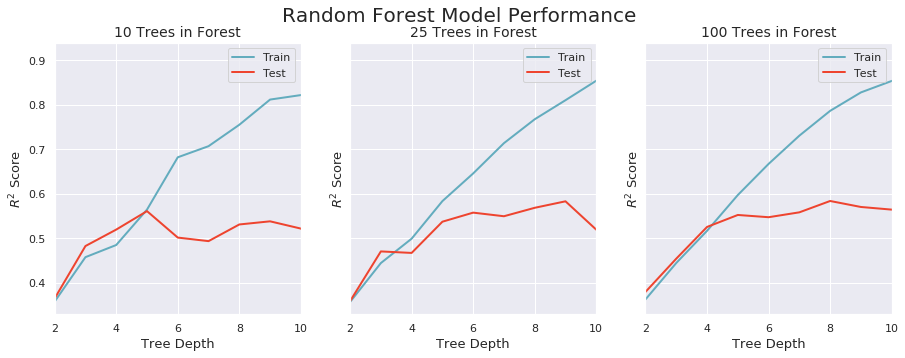

In [122]:
# Plot the different results to compare
axes = [(0,10),(1,25),(2,100)]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for c, n in axes:
    ax[c].set_title(f"{n} Trees in Forest", fontsize=14)
    ax[c].plot(depths, rf_scores[n]["train"], label="Train", color=c_blue, lw=2)
    ax[c].plot(depths, rf_scores[n]["test"], label="Test", color=c_or, lw=2)
    ax[c].set_xlabel("Tree Depth", fontsize=13)
    ax[c].set_xlim([2,10])
    ax[c].set_ylabel("$R^2$ Score", fontsize=13)
    ax[c].legend();

fig.suptitle('Random Forest Model Performance', fontsize=20);

fig.savefig('figs/forest_matrix_mini.png', dpi=200)

## KNN Models
The final model we want to explore is KNN, as this can possibly capture non-linear relationships better than guessing at the polynomial terms needed in simple linear regression. 

Let’s plot a large version of this one for the report and to get a better view.

In [109]:
ks = (1, 3, 5, 7, 10, 15, 20, 50, 75, 100)

knn_means = []
knn_stds = []
train_scores = []

for k in ks:
    kn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(kn, X_train, y_train, cv=5)
    knn_means.append(np.mean(scores))
    knn_stds.append(np.std(scores))
    kn.fit(X_train, y_train)
    train_scores.append(kn.score(X_train, y_train))

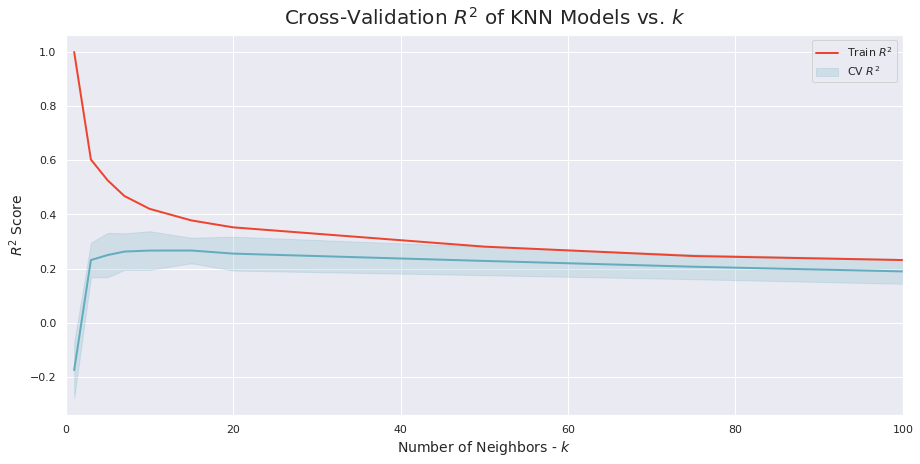

In [110]:
# Plot the results to compare
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(ks, knn_means, color=c_blue, lw=2)
ax.fill_between(ks, np.subtract(knn_means, knn_stds),
                 np.add(knn_means, knn_stds), alpha=0.2,
                 label="CV $R^2$", color=c_blue)
ax.plot(ks, train_scores, label="Train $R^2$", color=c_or, lw=2)
ax.set_xlabel("Number of Neighbors - $k$", fontsize=14)
ax.set_xlim([0,100])
ax.set_ylabel("$R^2$ Score", fontsize=14)
ax.set_title("Cross-Validation $R^2$ of KNN Models vs. $k$", fontsize=20, y=1.01)
ax.legend();

fig.savefig('figs/knn_full.png', dpi=200)

This model does not perform well at all. It scores less than the simple OLS model. This does support the idea that we wouldn’t be able to capture better performance by adding polynomial terms to the OLS model, as some non-linear relationship most likely would have showed up here. 